In [1]:
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report
from utils import create_param_list, create_train_data_hold_out, create_train_data_CV, inference
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(3407)

In [3]:
Q = 6
nconf = 81
ndata = 1000
L = 64
T_cr_1 = 0.701 # critical temp for 2d clock
T_cr_2 = 0.898 # critical temp for 2d clock
t_start = 0.4
exclude_T = (0.65, 0.75, 0.85, 0.95)

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Clock", q=Q)
# print(prm_list)
print(f"データ数:{nconf*ndata}")

データ数:81000


In [4]:
# # 可視化
# row = 2  # 行数
# col = 3  # 列数

# for num in range(4, 79, 5):
#     fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(8, 6))
#     fig.suptitle(f"temperature:{prm_list[num][0]}", fontsize=18, color='black')
#     for iconf in range(6):
#         _r = iconf//col
#         _c = iconf % col
#         file = f"{prm_list[num][1]}{iconf}.npy"
#         sc = np.load(file)

#         ax[_r,_c].set_xlabel('x')
#         ax[_r,_c].set_ylabel('y')
#         ax[_r,_c].imshow(sc, interpolation='nearest', vmin=0, vmax=Q-1, cmap='jet')

In [5]:
dataset, _ = create_train_data_CV(
    prm_list=prm_list, 
    ndata=ndata, 
    T_cr_1=T_cr_1, 
    T_cr_2=T_cr_2, 
    total_label=3,
    model_name="2d_Clock",
    Q=Q, 
    L=L, 
    exclude_T=exclude_T, 
    # normalize=True,
    # correlation_configuration=True
)
_, _, test_dataset = create_train_data_hold_out(
    prm_list=prm_list, 
    ndata=ndata, 
    T_cr_1=T_cr_1, 
    T_cr_2=T_cr_2, 
    total_label=3,
    model_name="2d_Clock",
    Q=Q, 
    L=L, 
    exclude_T=exclude_T, 
    # normalize=True,
    # correlation_configuration=True
)

In [6]:
BATCH_SIZE=2048
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("dataset.shape = ", len(dataset))
print("test_dataset.shape = ", len(test_dataset))

dataset.shape =  59000
test_dataset.shape =  39700


In [13]:
class CNNClassifier(nn.Module):
    def __init__(self, target_size):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 96, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12*12*96, 64)
        # self.fc1 = nn.Linear(14*14*128, 96)
        self.fc2 = nn.Linear(64, 48)
        self.fc3 = nn.Linear(48, target_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        # x = self.dropout1(x)
        x = self.relu(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = self.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        # x = self.dropout2(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

mps is available.
FOLD 1
--------------------------------
Epoch: 70, Validation loss: 4.826910983202821e-05, Accuracy: 97.92372881355932%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9774    0.9886      4996
           1     0.8885    0.9841    0.9338      1757
           2     0.9944    0.9794    0.9868      5047

    accuracy                         0.9792     11800
   macro avg     0.9610    0.9803    0.9697     11800
weighted avg     0.9810    0.9792    0.9797     11800



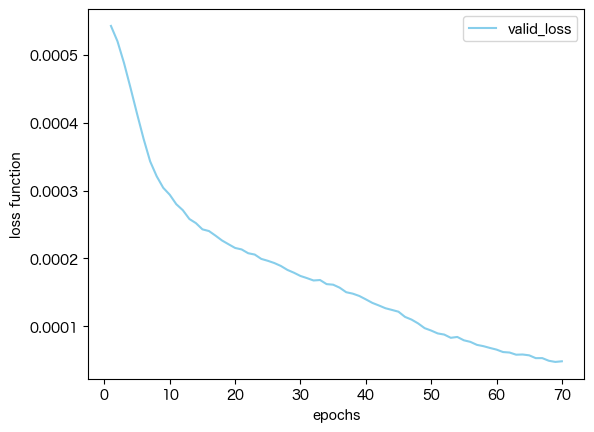

FOLD 2
--------------------------------
Epoch: 70, Validation loss: 4.2266929048602865e-05, Accuracy: 98.45762711864407%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9754    0.9876      5008
           1     0.9174    0.9902    0.9524      1840
           2     0.9963    0.9917    0.9940      4952

    accuracy                         0.9846     11800
   macro avg     0.9713    0.9858    0.9780     11800
weighted avg     0.9856    0.9846    0.9848     11800



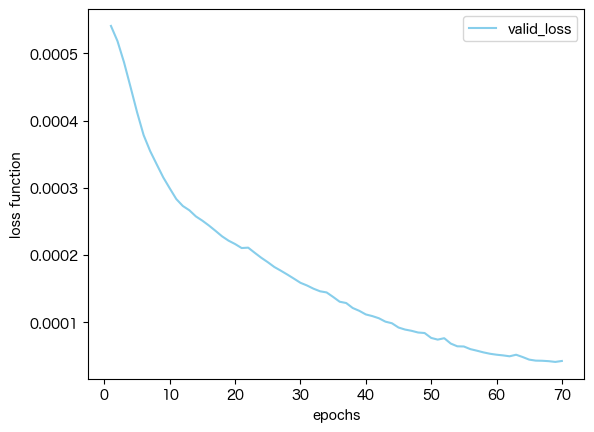

FOLD 3
--------------------------------
Epoch: 70, Validation loss: 4.134196282948478e-05, Accuracy: 97.27118644067797%
Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9972    0.9984      4946
           1     0.8491    0.9955    0.9165      1775
           2     0.9987    0.9409    0.9690      5079

    accuracy                         0.9727     11800
   macro avg     0.9492    0.9779    0.9613     11800
weighted avg     0.9766    0.9727    0.9734     11800



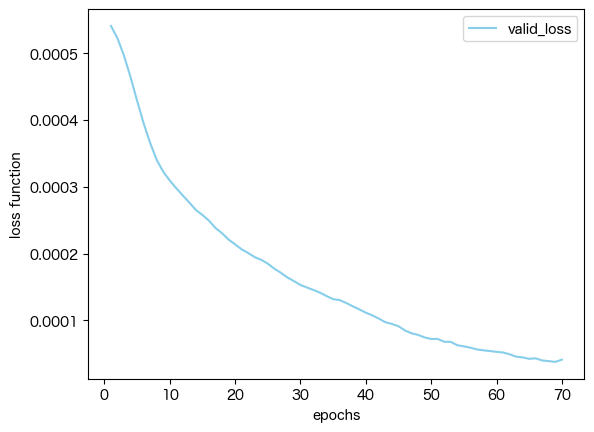

FOLD 4
--------------------------------
Epoch: 70, Validation loss: 3.4879056768397155e-05, Accuracy: 98.5677966101695%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9784    0.9891      5035
           1     0.9206    0.9917    0.9548      1801
           2     0.9970    0.9909    0.9939      4964

    accuracy                         0.9857     11800
   macro avg     0.9725    0.9870    0.9793     11800
weighted avg     0.9866    0.9857    0.9859     11800



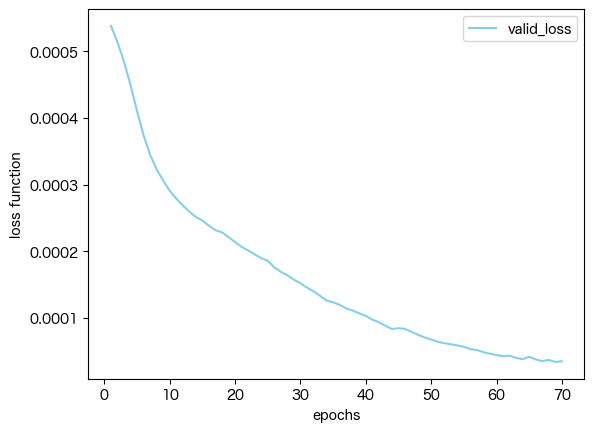

FOLD 5
--------------------------------
Epoch: 70, Validation loss: 2.4899269564677092e-05, Accuracy: 99.0677966101695%
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9944    0.9972      5015
           1     0.9483    0.9940    0.9706      1827
           2     0.9978    0.9857    0.9917      4958

    accuracy                         0.9907     11800
   macro avg     0.9820    0.9914    0.9865     11800
weighted avg     0.9911    0.9907    0.9908     11800



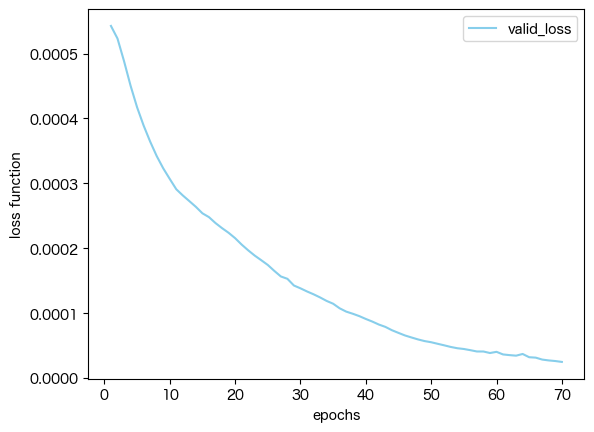

K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
Done.


In [18]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    print("mps is available.")

# hyper parameter
LEARNING_RATE = 0.00001
target_size = 3
grad_clip = 0.1
norm_type = 2
epochs = 70
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

y1s_mean, y2s_mean, y3s_mean = np.empty(nconf), np.empty(nconf), np.empty(nconf)
for fold, (train_data, valid_data) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_data)
    valid_subsampler = SubsetRandomSampler(valid_data)

    train_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
    valid_loader = DataLoader(
        dataset, batch_size=BATCH_SIZE, sampler=valid_subsampler)
    weights = torch.tensor([1.0, 4.0, 1.0]).to(device)

    model = CNNClassifier(target_size).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loss_list, vaild_loss_list, accuracy_list = [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.type(torch.long))
            train_loss += loss.item()
            loss.backward()
            del loss
            nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=grad_clip, norm_type=norm_type)
            optimizer.step()
        # train_loss_list.append(train_loss)

        model.eval()
        with torch.no_grad():
            valid_loss = 0
            correct = 0
            answer, prediction = [], []
            for data, _, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                valid_loss += criterion(output, target.type(torch.long)).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                prediction += list(pred.cpu().numpy())
                answer += list(target.cpu().numpy())

        valid_loss /= len(valid_loader.sampler.indices)
        accuracy = 100 * correct / len(valid_loader.sampler.indices)

        vaild_loss_list.append(valid_loss)
        accuracy_list.append(accuracy)
        if epoch == epochs - 1:
            print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
            print("Classification Report:\n", classification_report(answer, prediction, digits=4))
    plt.xlabel('epochs')
    plt.ylabel('loss function')
    # plt.plot(np.arange(1, epochs+1), train_loss_list, label="train_loss", color="orange")
    plt.plot(np.arange(1, epochs+1), vaild_loss_list,
             label="valid_loss", color="skyblue")
    plt.legend()
    plt.show()
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print("Done.")

In [21]:
torch.save(model, "../models/2d_Clock_q=6_model_classifier.pth")
# torch.save(model, "../models/2d_Clock_q=6_model_classifier_config.pth")

In [19]:
model = torch.load("../models/2d_Clock_q=6_model_classifier.pth")
# model = torch.load("../models/2d_Clock_q=6_model_classifier_config.pth")

answer_test, prediction_test, temps = [], [], []
model.eval()
for data, temp, target in test_loader:
    data = data.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=False)
    prediction_test += list(pred.cpu().numpy())
    answer_test += list(target.cpu().numpy())
    temps += list(temp.cpu().numpy())
xs, y1s, y2s, y3s = inference(len(test_dataset), temps, prediction_test, target_size)

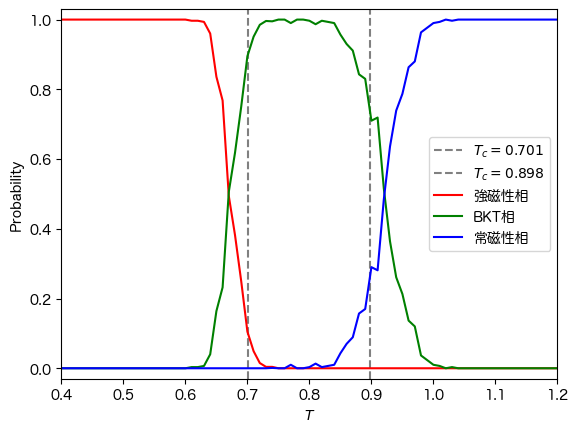

In [20]:
plt.axvline(x=T_cr_1, ymin=0, ymax=1, ls="dashed",
            color="gray", label=r"$T_c={}$".format(T_cr_1))
plt.axvline(x=T_cr_2, ymin=0, ymax=1, ls="dashed",
            color="gray", label=r"$T_c={}$".format(T_cr_2))
plt.xlim(t_start, t_end)
plt.ylim(-0.03, 1.03)
plt.plot(xs, y1s, label=r"強磁性相", color="red")
plt.plot(xs, y2s, label=r"BKT相", color="green")
plt.plot(xs, y3s, label=r"常磁性相", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()